In [3]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 4.9 MB/s 
     |████████████████████████████████| 4.0 MB 42.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 6.6 MB 28.4 MB/s 
     |████████████████████████████████| 1.8 MB 31.2 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
     |████████████████████████████████| 10.1 MB 21.0 MB/s 
     |████████████████████████████████| 325 kB 44.0 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 880 kB 41.9 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 144 kB 40.9 MB/s 
     |████████████████████████████████| 181 kB 47.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 46.4 MB/s 
     |████████████████████████████████| 136 kB 43.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.0 MB/s 
     |██████████████

In [4]:
import pandas as pd
import sklearn
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive

Mounted at /content/drive
MyDrive


In [8]:
data_path = '/content/drive/MyDrive/data test/olid-training-v1.0.tsv'

In [9]:
OLID_train = pd.read_csv(data_path, delimiter='\t', encoding='utf-8')
OLID_train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [10]:
OLID_train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) # rename columns if necessary
OLID_train['target'] = OLID_train.label.map({'NOT':0, 'OFF':1}) # convert label to a numerical variable
OLID_train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) # drop irrelevant columns
OLID_train.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [11]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

OLID_train['clean'] = OLID_train['text'].apply(lambda x: clean(x))
OLID_train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


# We only use the 'clean' column with *preprocessed text data* as input:

In [16]:
train = pd.DataFrame({'text': OLID_train.clean, 'labels': OLID_train.target})

In [17]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=42, 
                               stratify=train[['labels']])

In [18]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

11916
train: labels
0         7956
1         3960
dtype: int64


,text,labels
12900,user think would pick fun,0
10804,user bite transition complete,0
11237,user hol tl see tht big dick energy,1


In [19]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

1324
dev: labels
0         884
1         440
dtype: int64


,text,labels
352,user user said always praying even tho anythin...,0
3729,user user user user user user user user user u...,0
12763,user user another dem tactic leftist good cons...,0


In [20]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)

# Initial args
model_args.num_train_epochs=6
model_args.train_batch_size=64
model_args.learning_rate=1e-5 
model_args.max_seq_length=128 

# Early stopping to combat overfitting
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2 #55555555
model_args.evaluate_during_training_steps=32

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False


In [21]:
model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False

In [22]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args=model_args, use_cuda=True) 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [24]:
_, history = model.train_model(train, eval_df=dev, f1=sklearn.metrics.f1_score)

  0%|          | 0/11916 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

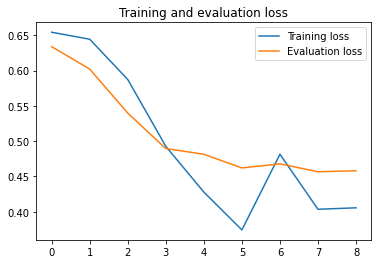

In [26]:
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend();

In [27]:
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

{'auprc': 0.7318706658552511,
 'auroc': 0.8473429144385027,
 'eval_loss': 0.45799355334546193,
 'fn': 144,
 'fp': 138,
 'mcc': 0.5184211418270074,
 'tn': 746,
 'tp': 296}

### Compare with results of BERT *with preprocessing* on the validation set:
    {'auprc': 0.7331613122683053,
     'auroc': 0.8566137906211435,
     'eval_loss': 0.4457666557955455,
     'fn': 134,
     'fp': 134,
     'mcc': 0.5438708350473056,
     'tn': 750,
     'tp': 306}
### (Re)construct Confusion Matrices from false/true negatives/positives based on evaluation on the dev set:

In [84]:
import seaborn as sns

def plotCM(cm, title):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label');
    
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['NOT','OFF'])
    ax.yaxis.set_ticklabels(['NOT','OFF'])

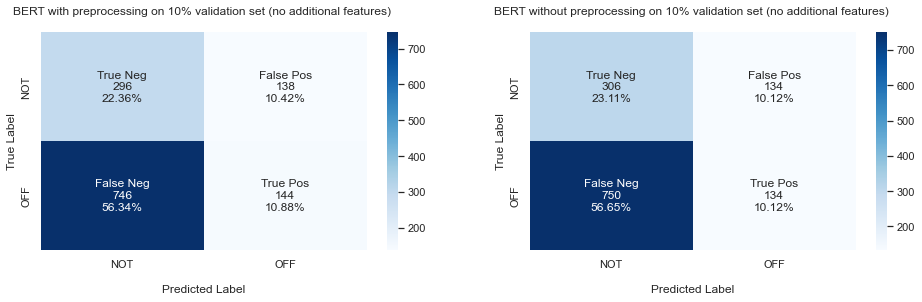

In [101]:
cm_with = np.array([[296, 138], [746, 144]])
cm_without = np.array([[306, 134], [750, 134]])

plt.subplot(1, 2, 1)
plotCM(cm_with, 'BERT with preprocessing on 10% validation set (no additional features) \n')

plt.subplot(1, 2, 2)
plotCM(cm_without, 'BERT without preprocessing on 10% validation set (no additional features) \n')

plt.subplots_adjust(right=2.2)

plt.savefig('BERTs_on_validation.png', bbox_inches="tight")

plt.show();

**Comparing BERT with preprocessing in this notebook to the same BERT without preprocessing (see the `Neural_no_preprocessing_no_features_Submissions` notebook in this folder), we observe a significant decrease in false negatives and false positives, and a corresponding increase in true negatives/positives in the latter system. We also observe a slight increase of `auprc`, `auroc`, and `eval_loss`, and a corresponding slight decrease in `mcc`. We conclude that `Neural_no_preprocessing_no_features_Submissions` contains the better model, and hence used it for the final submission we sent in for the shared task.**